In [14]:
## -- Non-Cartesian MRI recon using parallel processing
## -- Robby Thomen, 230923
## -- resources: https://youtu.be/fKl2JW_qrso, https://saturncloud.io/blog/python-parallelizing-gpu-and-cpu-work/
import os
parent_dir = os.getcwd()

#import winsound
import time
import mapvbvd
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
import scipy.io
import concurrent.futures # -- for parallel processing
import skimage.util # -- for image montages

In [15]:
# -- user defined functions --

In [16]:
def makeSlide(A):
    ''' displays 3D array as a 2D grayscale image montage'''
    plt.imshow(skimage.util.montage([abs(A[:,:,k]) for k in range(0,A.shape[2])], padding_width=1, fill=0),cmap='gray')
    plt.show()

In [17]:
def alarm():
    '''needs winsound module'''
    winsound.Beep(784, 70);winsound.Beep(740, 70);winsound.Beep(622, 70);winsound.Beep(440, 70);winsound.Beep(415, 70);winsound.Beep(659, 70);winsound.Beep(830, 70);winsound.Beep(1046, 70);

In [18]:
def gridMRIdata(trajlist,MRIdata,castlist):
    ''' This is pretty much just the griddata function but setup to 
        use the concurrent futures module to speed up interpolation 
        of large, complex datasets

    inputs: trajlist (Nx3 array of kx,ky,kz coords corresponding to MRIdata)
            MRIdata (length N vector of complex data)
            castlist (Nx3 array of kx, ky, kz to interpolate too)
    outputs: interpolated_data (Nx4 array of kx,ky,kz,interpolated complex data)
    '''
    Nblocks = 16
    interpolated_real = []; interpolated_imag = [];
    chunk_size = int(castlist.shape[0]/Nblocks)
    starttime = time.time()
    with concurrent.futures.ThreadPoolExecutor() as executor:
        realdata = [executor.submit(griddata, trajlist, np.real(MRIdata), 
                                    castlist[np.add(range(0,chunk_size),k*chunk_size),:]) 
                    for k in range(0,Nblocks)]
        concurrent.futures.wait(realdata)
        for f1 in realdata:
            interpolated_real.append(f1.result())
        imagdata = [executor.submit(griddata, trajlist, np.imag(MRIdata), 
                                    castlist[np.add(range(0,chunk_size),k*chunk_size),:]) 
                    for k in range(0,Nblocks)]
        concurrent.futures.wait(imagdata)
        for f2 in imagdata:
            interpolated_imag.append(f2.result())
    realdata = np.vstack(interpolated_real).flatten()
    imagdata = np.vstack(interpolated_imag).flatten()
    data = [complex(realdata[i], imagdata[i]) for i in range(len(realdata))]
    interpolated_data = np.column_stack((castlist[range(len(data)),:],data))
    completeTime = int(np.round((time.time() - starttime)))
    print(f'\n ## -- Time to interpolate {interpolated_data.shape[0]} points: {round(completeTime/60,2)} min. -- ##')
    return interpolated_data

In [19]:
def quadShift128(A):
    '''swaps the 8 corners of a 128x128x128 3D array (for later FFT)'''
    A = A[np.r_[64:128,0:64], :, :]
    A = A[:,np.r_[64:128,0:64], :]
    A = A[:,:,np.r_[64:128,0:64]]
    return A

In [20]:
def kspaceList_to_ImageArray(traj, data, N=128):
    '''turns Mx3 kSpace coords and M data into an NxNxN image'''
    F = np.zeros((N, N, N),dtype=np.complex_)
    for k in range(len(data)):
        F[int(round(traj[k, 0] + N / 2)), int(round(traj[k, 1] + N / 2)), int(round(traj[k, 2] + N / 2))] = data[k]
    F[~np.isfinite(F)] = 0
    print(F.shape)
    F = quadShift128(F)
    f = np.fft.ifftn(F)
    f = quadShift128(f)
    return f


In [21]:
def prepareCastlist(trajlist,N=128,s=1):
    '''given an Nx3 list of kSpace coordinates (trajlist), returns an Mx3 list of cartesian coords (castlist)'''
    trajlist = trajlist*s*N # -- trajlist coordinates are assumed to span -1/2 to 1/2
    mg = np.linspace(-N/2+1,N/2,N)
    kX,kY,kZ = np.meshgrid(mg,mg,mg,indexing='ij')
    castlist = np.column_stack((kX.flatten(),kY.flatten(),kZ.flatten()))
    castlist = castlist[np.sqrt(np.sum(castlist**2, axis=1)) < np.max(np.sqrt(np.sum(trajlist**2, axis=1))),:] ## let's not interpolate data outside of the trajectory sphere
    ## -- display the actual vs interpolated trajectories
    _, axs = plt.subplots(1,2,figsize = (11,5));axs[0].scatter(trajlist[:,0],trajlist[:,1],s =0.1);axs[1].scatter(castlist[:,0],castlist[:,1],s=0.1);plt.show()
    return trajlist, castlist

In [22]:
# -- main recon script --

In [23]:
## -- first we prepare the trajectory (just load it from file and put it in Nx3 list)
parent_dir = os.getcwd()
mat = scipy.io.loadmat(os.path.join(parent_dir,'traj/traj_dis_afia.mat'))
traj = mat['data']
kx = traj[:,:,0].flatten()
ky = traj[:,:,1].flatten()
kz = traj[:,:,2].flatten()
trajlist = np.column_stack((kx,ky,kz))

In [24]:
## -- Open the twix and organize the data into Nx5 matrix of cols [kx, ky, kz, gas, DP] -- ##
twix_obj = mapvbvd.mapVBVD(os.path.join(parent_dir, 'Data/meas_MID00205_FID12765_7_xe_radial_Dixon_2201_DP.dat')) # Load a DP dataset (This one from JM sequence)
twix_obj.image.squeeze = True #-------Remove singleton dimensions from data array
twix_obj.image.flagIgnoreSeg = True # Ignore the 'Seg' Dimension which
twix_obj.image.flagRemoveOS = False # Keep the oversampled data (all 64 points)
raw_fids = np.transpose(twix_obj.image.unsorted().astype(np.cdouble)) # -- This is a 2030x64 array for JM sequence
data_gas = raw_fids[:-30][0::2, :] # -- The 'gas' data is every other line beginning at row 0
data_dis = raw_fids[:-30][1::2, :] # -- The 'dis' data is every other line beginning at row 1
MRIdata = np.column_stack((trajlist,data_gas.flatten(),data_dis.flatten()))

pymapVBVD version 0.5.4
Software version: VD


Scan 1/1, read all mdhs:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

read data:   0%|          | 0/2030 [00:00<?, ?it/s]

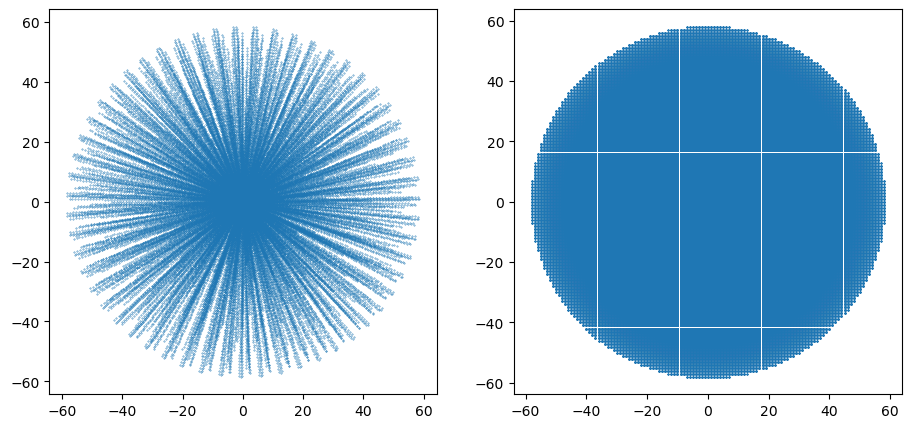

In [25]:
## -- prepare the list of Cartesian points for data to be interpolated to
scaledTrajlist, castlist = prepareCastlist(trajlist,N=128,s=1)

In [13]:
## -- perform data regridding by interpolation to castlist -- ##
interpolated_gas_data = gridMRIdata(scaledTrajlist,MRIdata[:,3],castlist)
interpolated_dis_data = gridMRIdata(scaledTrajlist,MRIdata[:,4],castlist)


 ## -- Time to interpolate 838960 points: 6.22 min. -- ##


KeyboardInterrupt: 

In [ ]:
# for linear interpolation:
# requested points outside of the convex hull of the input points are automatically 'nan'

In [27]:
# so how many nan values do we have?
non_nan_count = np.count_nonzero(~np.isnan(interpolated_gas_data))
nan_count = np.count_nonzero(np.isnan(interpolated_gas_data))

print('Non-NAN Values: ' + str(non_nan_count))
print('NAN Values: ' + str(nan_count))

nan_count/len(interpolated_gas_data)*100 # percentage of nan values 

Non-NAN Values: 3350913
NAN Values: 4927


0.587274721083246

/tmp/ipykernel_80190/672336382.py:5: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  F[int(round(traj[k, 0] + N / 2)), int(round(traj[k, 1] + N / 2)), int(round(traj[k, 2] + N / 2))] = data[k]
/tmp/ipykernel_80190/672336382.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  F[int(round(traj[k, 0] + N / 2)), int(round(traj[k, 1] + N / 2)), int(round(traj[k, 2] + N / 2))] = data[k]


(128, 128, 128)
(128, 128, 128)


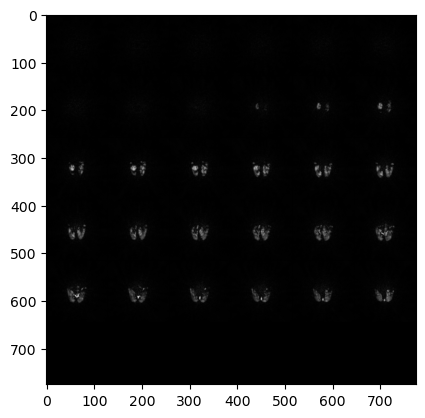

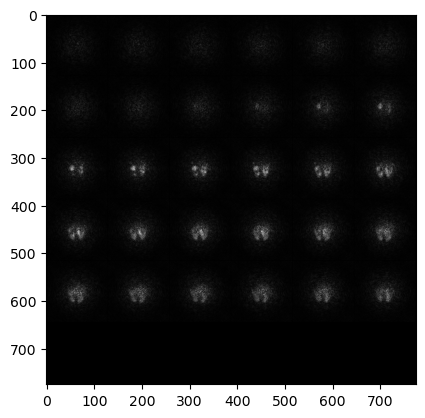

In [15]:
## -- reconstruct the image array from the interpolated data
gas_image = kspaceList_to_ImageArray(interpolated_gas_data[:,0:3],interpolated_gas_data[:,3])
dis_image = kspaceList_to_ImageArray(interpolated_dis_data[:,0:3],interpolated_dis_data[:,3])
makeSlide(gas_image[:,:,np.r_[40:70]])
makeSlide(dis_image[:,:,np.r_[40:70]])

In [16]:
fileName = f'meas_MID00205_FID12765_7_xe_radial_Dixon_2201_DP_reconData128_s1'
np.savez(os.path.join(parent_dir, fileName), MRIdata=MRIdata, gas_image=gas_image, dis_image=dis_image)
#alarm()

In [ ]:
# -- end of recon code --